### 1. Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
from shapely import ops as so
from shapely.geometry import box

import matplotlib
from matplotlib import pyplot as plt
from descartes import PolygonPatch
import seaborn as sns

In [3]:
from sentinelhub import WebFeatureService, WcsRequest, BBox, Geometry, CRS, SHConfig, FisRequest, CustomUrlParam, MimeType
from sentinelhub import DataSource

### 2. Import data

In [4]:
# Import Excel file
data = pd.ExcelFile('SentinelHubImage-available_dates.xlsx')
data_dates = data.parse('Tablib Dataset')

# Rename column names from Excel File
data_dates.columns = ['id', 'Farm', 'Date', 'Date_UTC', 'Validated']

# Change columns to datetime format
#data_dates.Date = pd.to_datetime(data_dates['Date'])
#data_dates.Date_UTC = pd.to_datetime(data_dates['Date_UTC'])

In [5]:
data_dates.head()

,id,Farm,Date,Date_UTC,Validated
0,14180,163,2020-04-20,2020-04-20 15:26:52,1
1,13892,163,2020-04-15,2020-04-15 15:26:57,1
2,11899,163,2020-03-11,2020-03-11 15:26:55,1
3,11202,163,2020-02-15,2020-02-15 15:26:51,1
4,10946,163,2020-02-10,2020-02-10 15:26:52,1


In [6]:
# Import json data
file = gpd.read_file('farm_map.json')

file.head()

,values,unit,geometry
0,"[ { ""value"": 3581.158766, ""variety"": { }, ""mea...","{'state': {'area': 6.530601, 'year_of_planting...","POLYGON ((-75.63966 -14.19970, -75.64232 -14.2..."
1,"[ { ""value"": 4037.375179, ""variety"": { }, ""mea...","{'state': {'area': 6.555069, 'year_of_planting...","POLYGON ((-75.64232 -14.20063, -75.64498 -14.2..."
2,"[ { ""value"": 4658.420440, ""variety"": { }, ""mea...","{'state': {'area': 6.533254, 'year_of_planting...","POLYGON ((-75.63899 -14.20153, -75.64165 -14.2..."
3,"[ { ""value"": 4196.272166, ""variety"": { }, ""mea...","{'state': {'area': 6.551013, 'year_of_planting...","POLYGON ((-75.64165 -14.20245, -75.64432 -14.2..."
4,"[ { ""value"": 4744.580970, ""variety"": { }, ""mea...","{'state': {'area': 6.534646, 'year_of_planting...","POLYGON ((-75.64165 -14.20245, -75.63899 -14.2..."


In [7]:
# The items in "values" columns are string. It is easier to read this information if every item is dict type

null = np.nan
file['values_conversion'] = [eval(file['values'][item][2:-2]) for item in range(len(file))]

# Drop values column and modify column names:
file = file.drop('values', 1)

file.columns = ['Name','Geometry', 'Info']

file.head()

,Name,Geometry,Info
0,"{'state': {'area': 6.530601, 'year_of_planting...","POLYGON ((-75.63966 -14.19970, -75.64232 -14.2...","{'value': 3581.158766, 'variety': {}, 'measure..."
1,"{'state': {'area': 6.555069, 'year_of_planting...","POLYGON ((-75.64232 -14.20063, -75.64498 -14.2...","{'value': 4037.375179, 'variety': {}, 'measure..."
2,"{'state': {'area': 6.533254, 'year_of_planting...","POLYGON ((-75.63899 -14.20153, -75.64165 -14.2...","{'value': 4658.42044, 'variety': {}, 'measurem..."
3,"{'state': {'area': 6.551013, 'year_of_planting...","POLYGON ((-75.64165 -14.20245, -75.64432 -14.2...","{'value': 4196.272166, 'variety': {}, 'measure..."
4,"{'state': {'area': 6.534646, 'year_of_planting...","POLYGON ((-75.64165 -14.20245, -75.63899 -14.2...","{'value': 4744.58097, 'variety': {}, 'measurem..."


In [8]:
file['Name'][0]

{'state': {'area': 6.530601,
  'year_of_planting': ['2019'],
  'variety': ['hass, fuerte, zutano']},
 'metadata': [{'level_name': 'empresa', 'name': 'agricola chapi', 'level': 2},
  {'level_name': 'fundo', 'name': 'don ernesto', 'level': 1},
  {'level_name': 'grupo', 'name': 'pal-1', 'level': 0},
  {'level_name': 'lote', 'name': '36', 'level': -1}],
 'id': 90214,
 'full_name': 'lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.36',
 'name': 'AGRICOLA CHAPI.DON ERNESTO.PAL-1.36'}

In [9]:
# Plot Polygons in order to visualize the spatial order

In [10]:
# Append in list "farm_polygons" all farm polygons
farm_polygons = []

[farm_polygons.append(file['Geometry'][item]) for item in range(len(file))];

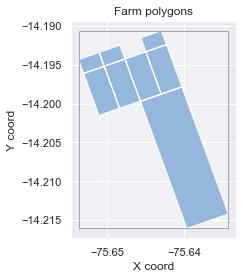

In [11]:
# Union of all polygons
farm= so.unary_union(farm_polygons)

# Bounding box for the farm
Bbox_farm_polygon = box(farm.bounds[0], farm.bounds[1], farm.bounds[2], farm.bounds[3])

# Hexadecimal colors
BLUE, GRAY, BLACK, WHITE = '#6699cc', '#999999', '#000000', '#ffffff'

# Set default Seaborn style
sns.set()

# Figure
fig = plt.figure()

ax = fig.gca(xlabel = 'X coord', ylabel = 'Y coord', title = 'Farm polygons') 
ax.add_patch(PolygonPatch(farm, fc=BLUE, zorder=1))

# Add a bounding box (rectangle)
ax.add_patch(PolygonPatch(Bbox_farm_polygon, fc=WHITE, ec=BLACK, alpha=0.3, zorder=2))
ax.axis('scaled')

plt.show()

### 3. Extract satellite images from Sentinel 2

In [12]:
INSTANCE_ID = 'e7d7de5c-b222-421a-b4fe-6e2bdf2d76a5'

In [13]:
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

In [14]:
boundary_farm = [farm.bounds[0], farm.bounds[1], farm.bounds[2], farm.bounds[3]]

Bbox_farm = BBox(bbox=boundary_farm, crs=CRS.WGS84)

In [15]:
time_interest = data_dates['Date']

In [16]:
time_interest

0     2020-04-20
1     2020-04-15
2     2020-03-11
3     2020-02-15
4     2020-02-10
         ...    
84    2016-12-22
85    2016-12-02
86    2016-11-22
87    2016-09-13
88    2016-07-15
Name: Date, Length: 89, dtype: object

In [17]:
farm_images = []

# This is going to loop over every date of interest (total=89). Save results in "farm_images" list.
for item in time_interest:
    
    # Request settings
    farm_request = WcsRequest(
        layer='TRUE-COLOR-S2-L1C',
        bbox=Bbox_farm,
        time=item,
        resx='4m',
        resy='4m',
        config=config)
    
    # Make request
    image = farm_request.get_data()
    
    # "farm_images" is a list where every element is a 3D array with each image requested. Load first image (index 0)
    farm_images.append(image[0])

In [18]:
# Save request to disk. At the end, in the current directory, it will be created a "1_Satellite_images" folder with every
# image extracted.

for item in time_interest:
    
    # Request settings
    farm_request = WcsRequest(
        data_folder = '1_Satellite_images/'+'{}'.format(item),
        layer='TRUE-COLOR-S2-L1C',
        bbox=Bbox_farm,
        time=item,
        resx='4m',
        resy='4m',
        image_format=MimeType.TIFF,
        config=config)
    
    # Save image requested to disk in folder "Satellite_images"
    farm_request.save_data()

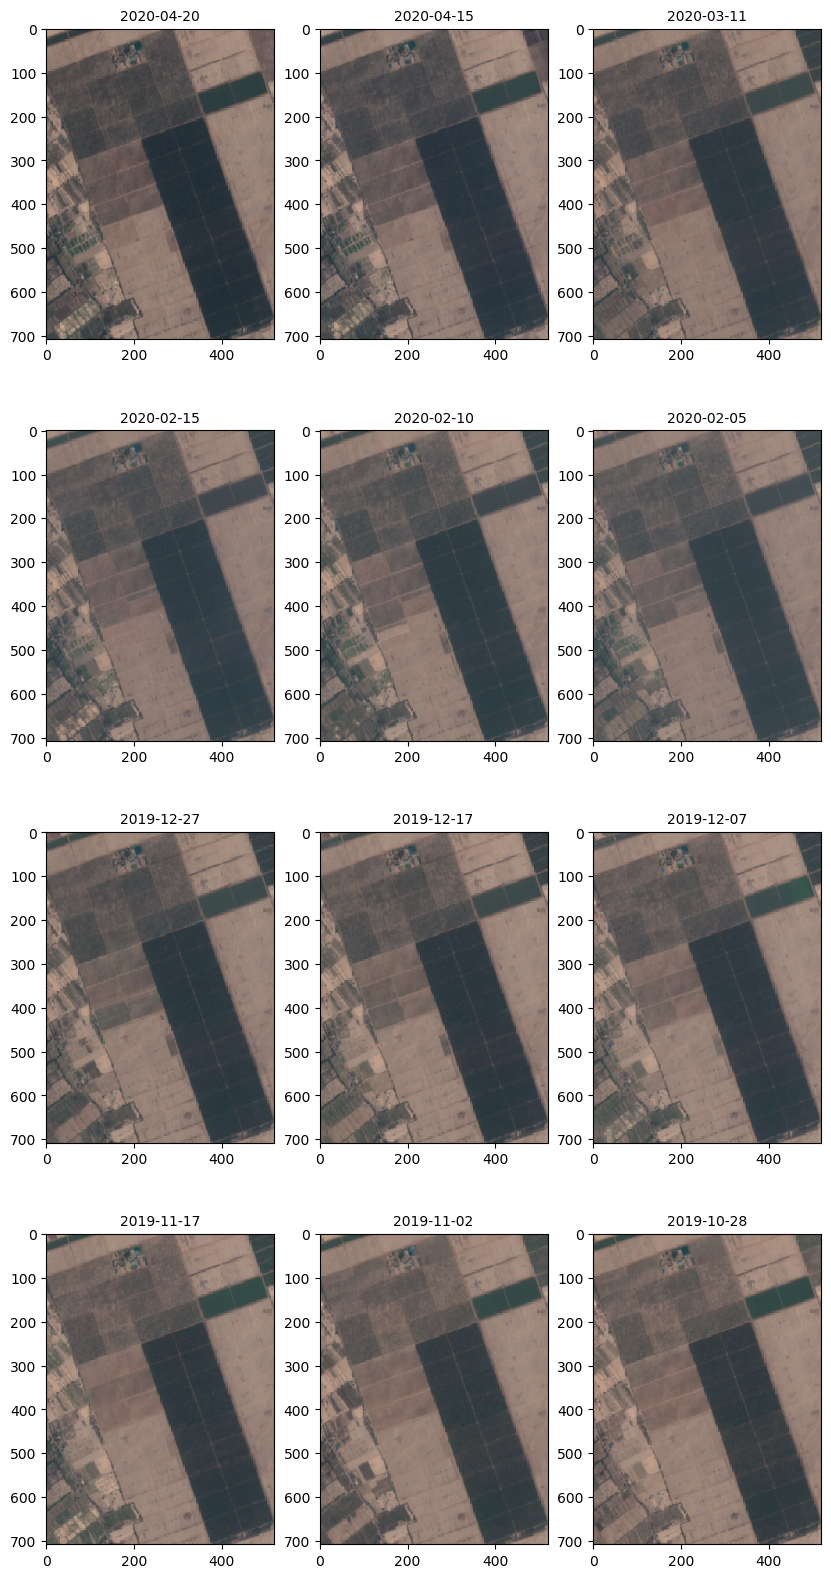

In [19]:
# In order to quality control, there will be plotting only first 12 images.
# If it is necessary to plot all sattelite images, it must be replaced:
# 1) Number "4" in subplots function to "len(farm_images) + 2) // 3" 
# 2) zip(farm_images[:12], time_interest[:12]) at the begining of loop to zip(farm_images, time_interest)

matplotlib.rc_file_defaults()

fig, axs = plt.subplots(4, 3, figsize=(10, 20))

for idx, (image, time) in enumerate(zip(farm_images[:12], time_interest[:12])):
    axs.flat[idx].imshow(image)
    axs.flat[idx].set_title(time, fontsize=10)

### 4. NDVI Statistics

In [20]:
# "geometry_list_farm" have farm polygons
geometry_list_farm = []

[geometry_list_farm.append(Geometry(file['Geometry'][item], CRS.WGS84)) for item in range(len(file))];

In [21]:
# This ndvi formula was extracted from https://sentinelhub-py.readthedocs.io/en/latest/examples/fis_request.html

ndvi_script = 'return [(B05 - B04) / (B05 + B04)]'

In [22]:
time_interest = data_dates['Date']

In [23]:
time_interest

0     2020-04-20
1     2020-04-15
2     2020-03-11
3     2020-02-15
4     2020-02-10
         ...    
84    2016-12-22
85    2016-12-02
86    2016-11-22
87    2016-09-13
88    2016-07-15
Name: Date, Length: 89, dtype: object

In [24]:
ndvi_fis_farm = []

# Use Feature Info Service package to obtain statistics about sattelite.
# This is going to loop over every 89 dates of interest.
# Folder "2_NDVI_statistics" will be created.

for item in time_interest:
    
    # Request settings
    ndvi_farm_request = FisRequest(
        layer='TRUE-COLOR-S2-L1C',
        geometry_list=geometry_list_farm,
        time=item,
        resolution='4m',
        
        # Create folder for each date
        data_folder='2_NDVI_statistics/'+'{}'.format(item),
        
        # Calculate NDVI
        custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
        config=config)

    # Save results into disk
    fis_data_farm = ndvi_farm_request.get_data(save_data=True)
    
    # "ndvi_fis_farm[x][y]": "x" is for each date. "y" is for each polygon 
    ndvi_fis_farm.append(fis_data_farm)

In [25]:
# Initialize columns in order to parse "ndvi_fis_farm" data into pandas DataFrame

COLUMNS = ['Polygon', 'Date', 'Min_ndvi', 'Max_ndvi', 'Mean_ndvi', 'StDev_ndvi']
date_ndvi = []
polygon_ndvi = []
min_ndvi = []
max_ndvi = []
mean_ndvi = []
sd_ndvi = []

In [26]:
# Fill columns with data
for item in ndvi_fis_farm:
    for polygon in range(len(item)):

        polygon_ndvi.append(polygon)
        date, stats = item[polygon]['C0'][0].items()
        
        date_ndvi.append(date[1])
        min_ndvi.append(stats[1]['min'])
        max_ndvi.append(stats[1]['max'])
        mean_ndvi.append(stats[1]['mean'])
        sd_ndvi.append(stats[1]['stDev'])

In [27]:
# DataFrame with basic statictics about NDVI

df_farm = pd.DataFrame(list(zip(polygon_ndvi, date_ndvi, min_ndvi, max_ndvi, mean_ndvi, sd_ndvi)), columns= COLUMNS)

In [28]:
df_farm.head()

,Polygon,Date,Min_ndvi,Max_ndvi,Mean_ndvi,StDev_ndvi
0,0,2020-04-20,-0.088480,0.289800,0.133825,0.046332
1,1,2020-04-20,-0.110135,0.248316,0.131625,0.042943
2,2,2020-04-20,-0.104072,0.290358,0.134126,0.036762
3,3,2020-04-20,-0.110135,0.261270,0.129561,0.032875
4,4,2020-04-20,-0.124415,0.278759,0.140234,0.040093


In [29]:
# There is two more unique data for each crop: Area and Yield. These data will be added to DataFrame

In [30]:
# Initialize columns 'Area' and 'Yield'
df_farm.insert(1,'Crop_Area (Ha)', 0)
df_farm.insert(2,'Crop_Yield (Kg/Ha)', 0)
#df_farm.loc[:,'Crop_Area'] = 0
#df_farm.loc[:,'Crop_Yield'] = 0

for item in range(len(file)):
    # Get values from file DataFrame
    value_area, value_yield = file['Name'][item]['state']['area'] , file['Info'][item]['value']

    # Get index for filter into "df_farm" DataFrame
    idx = df_farm[df_farm['Polygon']==item].index
    
    # Assing values
    df_farm.loc[idx,'Crop_Area (Ha)'] = value_area
    df_farm.loc[idx,'Crop_Yield (Kg/Ha)'] = value_yield

In [31]:
df_farm.head()

,Polygon,Crop_Area (Ha),Crop_Yield (Kg/Ha),Date,Min_ndvi,Max_ndvi,Mean_ndvi,StDev_ndvi
0,0,6.530601,3581.158766,2020-04-20,-0.088480,0.289800,0.133825,0.046332
1,1,6.555069,4037.375179,2020-04-20,-0.110135,0.248316,0.131625,0.042943
2,2,6.533254,4658.420440,2020-04-20,-0.104072,0.290358,0.134126,0.036762
3,3,6.551013,4196.272166,2020-04-20,-0.110135,0.261270,0.129561,0.032875
4,4,6.534646,4744.580970,2020-04-20,-0.124415,0.278759,0.140234,0.040093


### 5. NDVI Images

In [32]:
# This is going to loop over every date of interest in order to save NDVI farm images into disk.
# Folder "3_NDVI_images" will be created.

for item in time_interest:
    
    #Request
    ndvi_image_request = WcsRequest(
        data_folder = '3_NDVI_images/'+'{}'.format(item),
        layer='TRUE-COLOR-S2-L1C',
        bbox=Bbox_farm,
        time=item,
        resx='4m',
        resy='4m',
        custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
        image_format=MimeType.TIFF,
        config=config)

    ndvi_image_request.save_data()

### 6. Exploratory Data Analysis

In [33]:
df_farm.describe()

,Polygon,Crop_Area (Ha),Crop_Yield (Kg/Ha),Min_ndvi,Max_ndvi,Mean_ndvi,StDev_ndvi
count,2937.000000,2937.000000,2937.000000,2937.000000,2937.000000,2937.000000,2937.000000
mean,16.000000,6.434269,3587.437867,-0.060327,0.185205,0.090951,0.026642
std,9.523526,0.117636,1859.386120,0.037539,0.081139,0.058677,0.011733
min,0.000000,6.191944,537.120263,-0.166261,0.024988,-0.011761,0.005946
25%,8.000000,6.330826,1474.845976,-0.087253,0.108415,0.035008,0.016038
50%,16.000000,6.469184,4245.596105,-0.057715,0.200482,0.093516,0.026727
75%,24.000000,6.536344,5116.360841,-0.028798,0.252437,0.139887,0.035894
max,32.000000,6.575069,6276.873685,0.043416,0.382460,0.242496,0.069594


In [34]:
# Set default Seaborn style
sns.set()

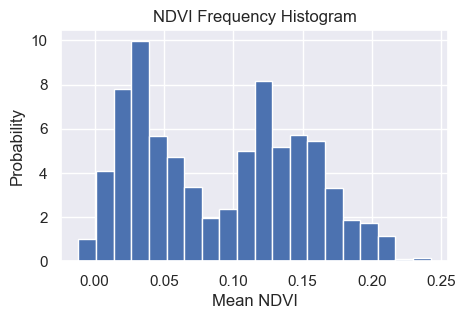

In [35]:
fig, axs = plt.subplots(figsize=(5, 3))

plt.hist(df_farm['Mean_ndvi'], bins=20, density=True);
plt.title('NDVI Frequency Histogram', fontsize=12);
plt.xlabel('Mean NDVI', fontsize=12);
plt.ylabel('Probability', fontsize=12);
plt.show()

In [36]:
# Column "Date" is convert to datetime object and pass to index
df_farm.index = df_farm['Date']
df_farm.index = pd.to_datetime(df_farm.index)

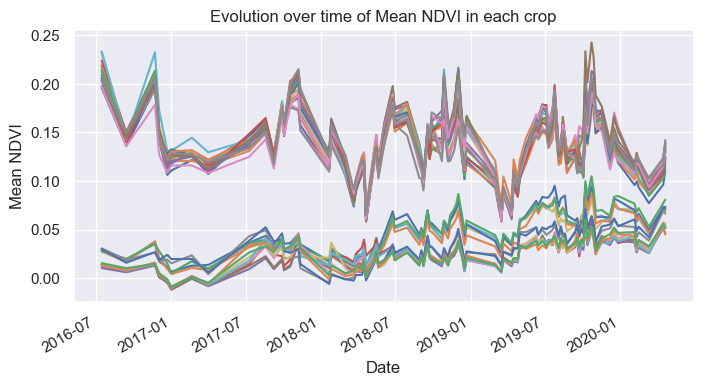

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))

for item in range(len(file)):
    df_farm[df_farm['Polygon']==item]['Mean_ndvi'].plot(ax = ax, label='{}'.format(item))
plt.title('Evolution over time of Mean NDVI in each crop', fontsize=12)
plt.ylabel('Mean NDVI', fontsize=12);
plt.show()

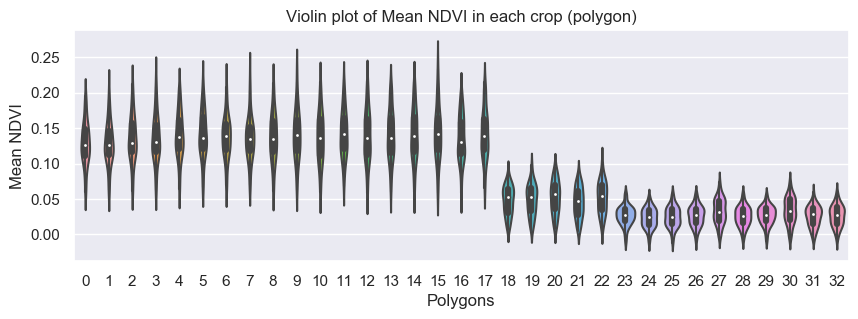

In [38]:
fig, ax = plt.subplots(figsize=(10, 3))

ax = sns.violinplot(x='Polygon', y='Mean_ndvi', data=df_farm);
plt.title('Violin plot of Mean NDVI in each crop (polygon)', fontsize=12);
plt.xlabel('Polygons', fontsize=12);
plt.ylabel('Mean NDVI', fontsize=12);
plt.show()

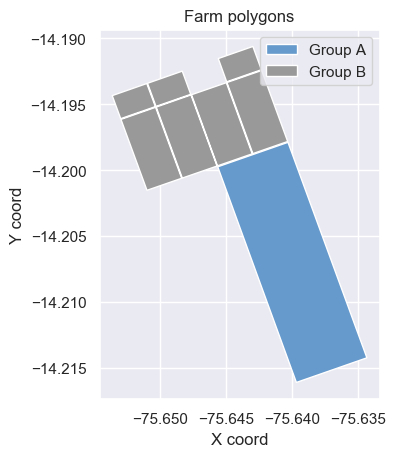

In [39]:
# Append in list "farm_polygons" all farm polygons
farm_groupA = []
farm_groupB = []

[farm_groupA.append(file['Geometry'][item]) for item in range(0,18)];
[farm_groupB.append(file['Geometry'][item]) for item in range(18,len(file))];

# Union of all polygons
farm_A= so.unary_union(farm_groupA)
farm_B= so.unary_union(farm_groupB)

fig = plt.figure()

ax = fig.gca(xlabel = 'X coord', ylabel = 'Y coord', title = 'Farm polygons') 
ax.add_patch(PolygonPatch(farm_A, fc=BLUE, zorder=1, label='Group A'))
ax.add_patch(PolygonPatch(farm_B, fc=GRAY, zorder=2, label='Group B'))
ax.axis('scaled')
plt.legend()
plt.show()

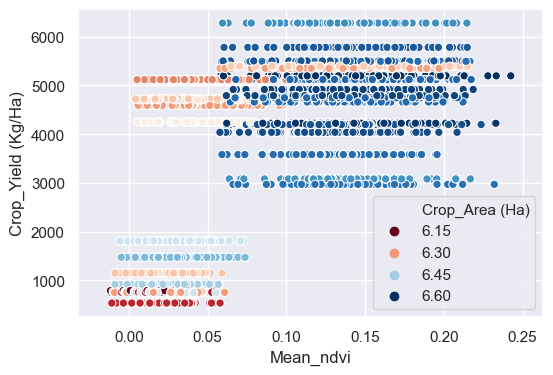

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

ax = sns.scatterplot(x='Mean_ndvi', y='Crop_Yield (Kg/Ha)', data=df_farm, hue='Crop_Area (Ha)', palette = 'RdBu')

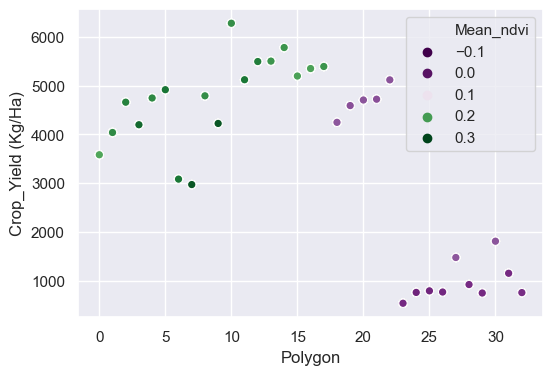

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))

ax = sns.scatterplot(x='Polygon', y='Crop_Yield (Kg/Ha)', data=df_farm, hue='Mean_ndvi', palette = 'PRGn')

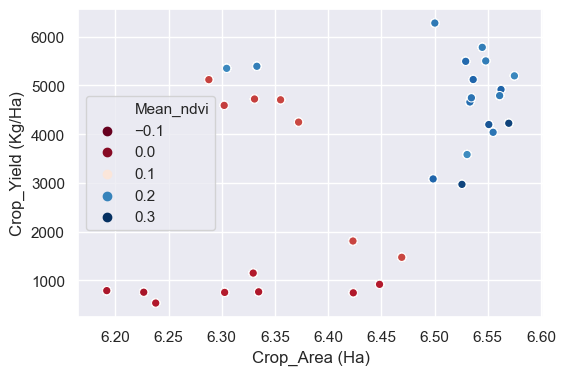

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

ax = sns.scatterplot(x='Crop_Area (Ha)', y='Crop_Yield (Kg/Ha)', data=df_farm, hue='Mean_ndvi', palette = 'RdBu')